### Calculating Observables for the Equilibrium case


In [4]:
import numpy as np 
import math 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import glob
from itertools import product

The spin-spin correlation function can be calculated as follows,
\begin{equation}
C(i,j) = \sum_{i,j} \langle S_{i}.S_{j}\rangle
\end{equation}

The spin component can be obrained from the angle $\theta_{i}$ and the dot product can be written as,
\begin{equation}
C(i,j) = \sum_{i,j} \langle S_{i,x}S_{j,x} + S_{i,y}S_{j,y}\rangle
\end{equation}

Using some arithematic manipulation we can write the correlation fn as,
\begin{equation}
C(i,j) = \sum_{i,j} (\langle S_{i,x}S_{j,x} \rangle + \langle S_{i,y}S_{j,y} \rangle)
\end{equation}

In terms of correlation fn matrix $\langle  S_{i,x}S_{j,x}\rangle = M_{x,ij}$  and 
$\langle  S_{i,y}S_{j,y}\rangle = M_{y,ij}$.
The correlation function is,
\begin{equation}
C(i,j) = \sum_{ij} M_{x,ij} +\sum_{ij} M_{y,ij}
\end{equation}
The process of calculating the correlation function can be reduced to,
* First calculate the matrix of correlation fn for x component and y component.
* Calculate the matrix for each monte carlo configuration and sum over all the sites.

In [47]:
## class definition to measure equilibrium observable values
class Fileload:
    def __init__(self,L,file_path,fpattern):
        '''
        This function will initialize the instance of the class
        parameters:
            self(object): 
            L(integer): The system size
            file_path(string): location where the files are stored
        return:
            None
        '''

        self.L = L 
        self.n_sites = self.L**2
        self.file_path = file_path
        self.fpattern = fpattern
    
    ### this function will find the files using some  pattern and location
    def findfiles(self):
        '''
        This function will find the files given a file path
        parameters:
            self(object): the class instance.
        return:
            None 
        '''
        flist = glob.glob(self.file_path+self.fpattern)
        flist_dict = {} 
        for j in flist:
            kis,vis = float(j.split('tfinal')[1].split('.dat')[0]),j
            flist_dict[kis]=vis
        self.files = dict(sorted(flist_dict.items()))

     ### given a temperature index this function will load the data
    def loaddata(self, j):
        '''
        This function will load the lattice configuration for the given key from 
        the data
        parameters:
            self(object): Instance of the class
            j(float): the temperature value for which we wantt to  load the data
        return:
            data_ti (dataframe): dataframe for a given data
        '''
        data_ti = pd.read_csv(
            self.files[j], header=None, index_col=[0], sep='\t')
        data_ti = data_ti.dropna(axis=1)
        data_ti.columns = [f'theta{i}' for i in range(self.n_sites)]
        self.n_mc = data_ti.shape[0]
        self.df = data_ti
    


### this class defines the way we calculate the observables
class ObservableDef(Fileload):
    ## creating the instance of the class using
    ## the initializer of the parent class
    def __init__(self,L,file_path,fpattern):
        super(ObservableDef,self).__init__(L,file_path,fpattern)

    
    def neighbors(self):
        '''
        This function will create neighbour table 
        parameters:
            self(object): The class instance
        return :
            None
        '''
        ## incrementing a site by 1 keeping in mind the boundary condition
        ip = lambda x:(x+1)%self.L

        ## decrementing a site by 1 keeping in mind the boundary condition
        im = lambda x:(x-1+self.L)%self.L

        ri,li,ui,di = [],[],[],[]
        for i in range(self.n_sites):
            yi,xi = divmod(i,self.L)
            ri.append(ip(xi)+yi*self.L)
            li.append(im(xi)+yi*self.L)
            ui.append(xi+ip(yi)*self.L)
            di.append(xi+im(yi)*self.L)

        self.right,self.left = np.array(ri,dtype='int'),np.array(li,dtype='int')
        self.up,self.down = np.array(ui,dtype='int'), np.array(di,dtype='int')

   
        
    
    ### function to calculate the sx and sy component of the spin using the angle theta
    def componentsxsy(self):
        '''
        This function given the angle theta will calculate the sx and sy component
        sx_i --> cos(theta_i) , sy_i --> sin(theta_i)
        parameters:
            self(object): class instance
        return: 
            None
        '''
        data_sx = self.df.apply(lambda x:np.cos(x))
        data_sy = self.df.apply(lambda x:np.sin(x))
        self.data_sx = data_sx
        self.data_sy = data_sy

    ### function to calculate the spin spin correlation function
    def corrcalc(self):
        '''
        This function will calculate the spin spin correlation function given sx,sy arrays
        parameters:
            self(object): Class instance
        return:
            None
        '''
        mx = np.zeros((self.n_sites,self.n_sites))
        n_conf = 100
        for j in range(n_conf):
            temp_v1 = self.data_sx.iloc[j,:].values.reshape(-1,1)
            temp_v2 = self.data_sx.iloc[j, :].values.reshape(1, -1)
            cxij = np.matmul(temp_v1,temp_v2)
            mx += cxij
        mx = mx/n_conf
        my = np.zeros((self.n_sites,self.n_sites))
        for j in range(n_conf):
            temp_v1 = self.data_sy.iloc[j,:].values.reshape(-1,1)
            temp_v2 = self.data_sy.iloc[j, :].values.reshape(1, -1)
            cyij = np.matmul(temp_v1,temp_v2)
            my += cyij
        my = my/n_conf
        self.corr_mat = mx+my
        
    
    ### this function will convert the spin-spin correlation function into a smaller subspace (0,L-1) & (0,L-1)
    def averagedcf(self):
        '''
        Here we calculate the correlation function on the square lattice of size L
        parameters:
            self(object): instance of the class
        return:
            cmat(dictionary): 
        '''
        cmat = np.zeros((self.L,self.L))
        for i,j in product(np.arange(self.n_sites),np.arange(self.n_sites)):
            yi,xi = divmod(i,self.L)
            yj,xj = divmod(j,self.L)
            delx = abs(xj-xi)
            dely = abs(yj-yi)
            cmat[delx,dely] += self.corr_mat[i,j]

        return cmat

In [48]:
L = 24
fpattern=f'noquen*sweep*{L}*.dat'
file_path = "./"

## creating the object of the class EqObservables
obse = ObservableDef(L,file_path,fpattern)

## creating dictionary of files within the folder
obse.findfiles()

## create neighbour table
obse.neighbors()


## getting data for each temperature
obse.loaddata(1.20)
obse.componentsxsy()
obse.corrcalc()
cmt = obse.averagedcf()


### Order parameters
The order parameter in this case is given by,
\begin{equation}
m^{2} = m^{2}_{x} + m^{2}_{y}
\end{equation}
The component $m_{x}$ is given by,
\begin{equation}
m_{x} = \frac{1}{N} \sum_{i} \cos \theta_{i}
\end{equation}
and the component $m_{y}$ is given by,
\begin{equation}
m_{y} = \frac{1}{N} \sum_{i} \sin \theta_{i}
\end{equation}

In [61]:
mc_data =  pd.DataFrame()
for j in obse.files:
    obse.loaddata(j)
    obse.componentsxsy()
    tmp_temp = j*np.ones(obse.n_mc)
    avg_my = obse.data_sy.mean(axis=1)
    avg_mx = obse.data_sx.mean(axis=1)
    temp_df = pd.DataFrame({'temp':tmp_temp, 
                            'mx':avg_mx,'my':avg_my})
    mc_data = pd.concat([mc_data,temp_df])
mc_data['m2'] = mc_data.mx **2 + mc_data.my**2

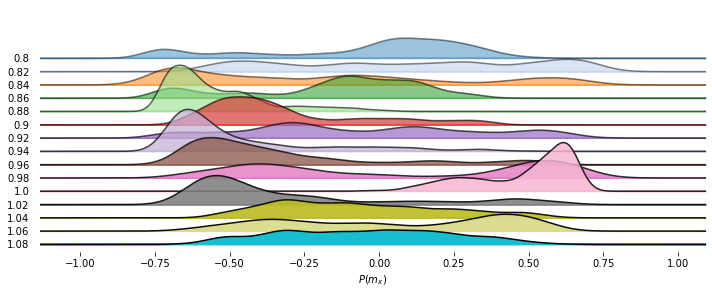

In [100]:
from matplotlib import cm 
from joypy import joyplot
'''
palette = cm.tab20
g = sns.FacetGrid(data=mc_data[mc_data.temp<1.0],hue='temp',row='temp',aspect=8,height=1.5,sharex=True,sharey=True)
g.map_dataframe(sns.kdeplot,"mx")
g.map_dataframe(sns.kdeplot,"mx",fill=True)
#g.set_titles("")
g.set(yticks=[])
g.despine(left=True)
plt.subplots_adjust(hspace=0.00001)#,wspace=-2.0)

plt.show()
'''

joyplot(data=mc_data[mc_data.temp<1.1], by='temp',column="mx", colormap=cm.tab20, fade=True, figsize=(10, 4))
plt.xlabel(r'$P(m_{x})$')

plt.show()



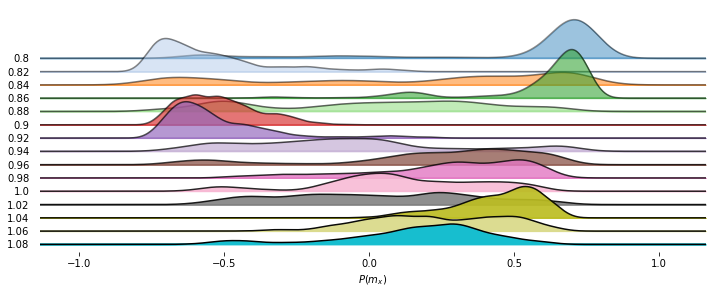

In [99]:
joyplot(data=mc_data[mc_data.temp<1.1], by='temp', column="my",
        colormap=cm.tab20, fade=True, figsize=(10, 4))
plt.xlabel(r'$P(m_{y})$')
plt.show()


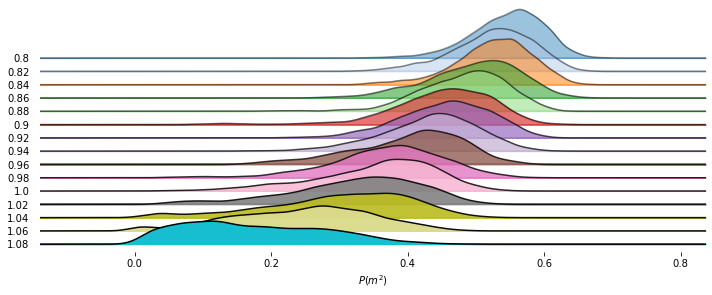

In [101]:
joyplot(data=mc_data[mc_data.temp<1.1], by='temp', column="m2",
        colormap=cm.tab20, fade=True, figsize=(10, 4))
plt.xlabel(r'$P(m^{2})$')

plt.show()


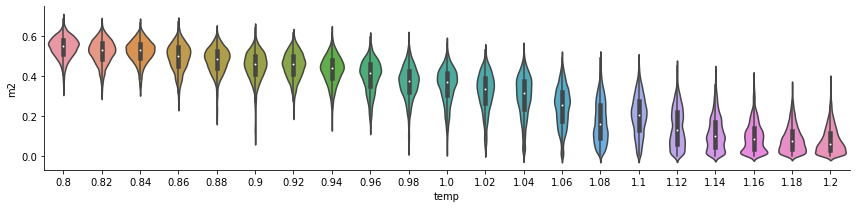

In [121]:
sns.catplot(x='temp',y='m2',data=mc_data,kind='violin',height=3,aspect=4)
plt.show()

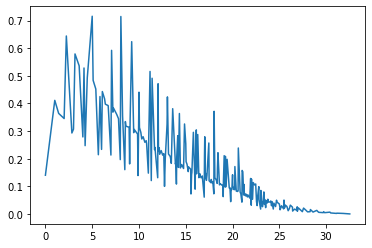

In [12]:
val_dict = {}
for i, j in product(np.arange(obse.L), np.arange(obse.L)):
    r = np.sqrt(i**2+j**2)
    if r in list(val_dict.keys()):
        val_dict[r] += cmt[i, j]
    else:
        val_dict[r] = cmt[i, j]
vadlr = dict(sorted(val_dict.items()))

plt.plot(list(vadlr.keys()),np.array(list(vadlr.values()))/4096)
plt.show()


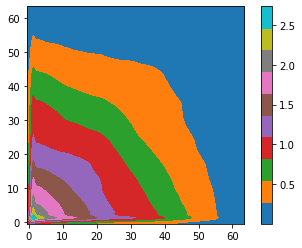

In [170]:
plt.imshow(cmt/obse.n_sites,origin='lower',cmap='tab10',interpolation='spline36')
plt.colorbar()
plt.show()

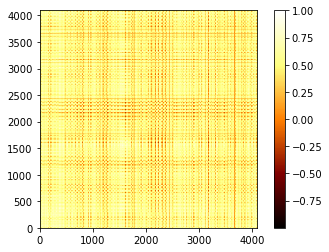

In [110]:
plt.imshow(obse.corr_mat,cmap='afmhot',origin='lower')
plt.colorbar()
plt.show()

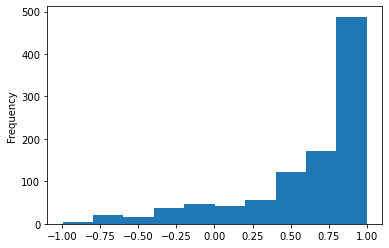

In [89]:
obse.data_sx['theta0'].plot(kind='hist')
plt.show()

In [137]:
ex_di =  {}
ex_di[0] = 1
ex_di[1]  = 1
ex_di[0] += 2
print(list(ex_di.keys()))

[0, 1]


In [5]:
data = pd.read_csv(obse.files[1.20],index_col=[0],sep='\t',header=None)
data.columns=['Enr','mx','my','m2']
data.head()


,Enr,mx,my,m2
0,,,,
0,-0.349560,-0.015966,0.021860,0.027070
1,-0.537578,-0.025443,0.022859,0.034204
2,-0.657086,-0.043232,0.017636,0.046691
3,-0.720690,-0.041812,0.011951,0.043487
4,-0.772755,-0.023977,0.011115,0.026428


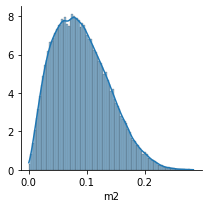

In [93]:
g = sns.FacetGrid(data)
g.map_dataframe(sns.histplot,'m2',fill=True,kde=True,stat='density')
plt.show()


In [116]:
divmod(1,2)

(0, 1)

In [118]:
c = 0 
c+=1;print(c)

c+=3;print(c)


1
4
